In [20]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU, PerceptronBN, PerceptronDO, PerceptronBD
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity, create_ratio_and_intensity, create_row_combos
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
DATA_PATH = r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc3.pkl'

data = pd.read_pickle(DATA_PATH)
# Drop Thickness values which I did not calculate the close concnetration points
equidistance_detector_normalization(data)

# Drop Uterus Thickness for now
data = data.drop(columns='Uterus Thickness')

# Interpolate intensity to remove noise
data = interpolate_exp(data, weights=(1, 0.7))
data['Intensity'] = data['Interpolated Intensity']
data = data.drop(columns='Interpolated Intensity')

# Manual log(intensity) normalization
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log


# data = create_ratio_and_intensity(data, True)
# data, x_columns, labels = create_ratio(data, True)
data, x_columns, labels = create_spatial_intensity(data)

# data.head()
# NOTE: Have only 1 on at the same time!

# Cleanup
data.dropna(inplace=True)

# Create Combinations

In [23]:
# Add new columns to group close concentrations
# data['MconcCenters'] = np.round(data['Maternal Hb Concentration']).astype(int)
data['FconcCenters'] = np.round(data['Fetal Hb Concentration'] * 20, 0)
fixed_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Saturation", "FconcCenters"]
data, x_columns, labels = create_row_combos(data, x_columns, fixed_columns, ["Fetal Hb Concentration"], combo_count=2)
print(labels)

['Maternal Wall Thickness', 'Maternal Hb Concentration', 'Maternal Saturation', 'Fetal Saturation', 'FconcCenters', 'Fetal Hb Concentration 0', 'Fetal Hb Concentration 1']


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [24]:
# For the forward model, x -> The labels/TMPs i.e., the input to the model
x_columns = labels.copy()
x_columns.remove('FconcCenters')

## Y -> The features to predict, output of the model
ratio_columns = list(filter(lambda X: X.isdigit(), data.columns))   # Can be empty 
intensity_columns = list(filter(lambda X: '_' in X, data.columns))  # Can be empty 
y_columns = ratio_columns + intensity_columns

## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

In [25]:
data.describe()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_77,x_78,x_79,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Saturation,FconcCenters,Fetal Hb Concentration 0,Fetal Hb Concentration 1
count,5.150000e+04,5.150000e+04,5.150000e+04,5.150000e+04,5.150000e+04,5.150000e+04,5.150000e+04,5.150000e+04,5.150000e+04,5.150000e+04,...,5.150000e+04,5.150000e+04,5.150000e+04,5.150000e+04,5.150000e+04,5.150000e+04,5.150000e+04,51500.000000,5.150000e+04,5.150000e+04
mean,5.111691e-13,-1.802875e-13,2.809721e-14,8.234018e-15,2.992502e-14,1.106405e-14,-3.288309e-14,-2.521861e-14,1.962036e-14,-4.351446e-14,...,6.128052e-15,6.004431e-16,-4.321424e-14,7.064037e-17,1.854310e-16,1.246692e-15,8.616193e-17,2.728155,-4.525398e-17,-9.492299e-17
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,...,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,0.444915,1.000010e+00,1.000010e+00
min,-2.655479e+00,-1.361816e+00,-1.324031e+00,-1.311535e+00,-1.751095e+00,-2.018314e+00,-2.458896e+00,-2.751767e+00,-3.057090e+00,-3.261551e+00,...,-3.484365e+00,-3.521678e+00,-3.550383e+00,-1.437876e+00,-1.462280e+00,-1.414214e+00,-1.414214e+00,2.000000,-1.960385e+00,-1.960385e+00
25%,-6.544556e-01,-7.069781e-01,-7.348542e-01,-7.446917e-01,-8.911100e-01,-8.835831e-01,-8.485697e-01,-8.058049e-01,-7.411502e-01,-6.887725e-01,...,-8.161061e-01,-8.185276e-01,-8.189804e-01,-8.963727e-01,-7.571543e-01,-7.071068e-01,-7.071068e-01,2.000000,-7.527314e-01,-7.527314e-01
50%,-3.293674e-02,-3.413246e-01,-3.914362e-01,-3.936744e-01,-1.421642e-01,-8.415316e-02,-2.422660e-02,1.854206e-02,6.299182e-02,9.511829e-02,...,1.318810e-01,1.444594e-01,1.543058e-01,1.866348e-01,-5.202868e-02,0.000000e+00,0.000000e+00,3.000000,-2.813949e-02,-2.813949e-02
75%,5.817656e-01,4.129812e-01,5.958339e-01,6.426249e-01,9.006186e-01,8.972979e-01,8.872830e-01,8.768054e-01,8.619735e-01,8.505704e-01,...,8.333147e-01,8.276332e-01,8.225438e-01,7.281385e-01,7.236095e-01,7.071068e-01,7.071068e-01,3.000000,6.964524e-01,6.964524e-01
max,3.025937e+00,2.429430e+00,2.206100e+00,2.142614e+00,1.713573e+00,1.666294e+00,1.604175e+00,1.554916e+00,1.496052e+00,1.451918e+00,...,1.435640e+00,1.435055e+00,1.434437e+00,2.352650e+00,1.569760e+00,1.414214e+00,1.414214e+00,3.000000,1.421044e+00,1.421044e+00


## Model Configuration

In [26]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory
datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 64, 'shuffle': True, 'num_workers': 2
        }, 
    'x_columns': x_columns,
    'y_columns': y_columns,
    # Standard Scaling w.r.t. Maternal Wall thickness : The original values are gone. Hold one out for some value
    # in the middle of the pack
    'validation_method' : HoldOneOut('Maternal Wall Thickness', data["Maternal Wall Thickness"].unique()[4])
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}

# trainer_factory = ModelTrainerFactory(PerceptronReLU, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronBN, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
# trainer_factory = ModelTrainerFactory(PerceptronDO, {'node_counts' : [IN_FEATURES, 8, 2, OUT_FEATURES]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())
trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 10, 20, OUT_FEATURES], 'dropout_rates': [0.01, 0.01, 0.01]}, generate_data_loaders, datagen_kw, 100, nn.MSELoss())

## Hyper Parameter Tuning

In [27]:
# Custom Train Function 
def train_with_tuning(iteration_config):
    set_seed(42)
    trainer_tuning = trainer_factory.create()
    trainer_tuning.reporting = True     # Report at each epoch to Ray Tune
    if 'batch_size' in iteration_config:
        trainer_tuning.change_batch_size(iteration_config['batch_size'])    # If batch_size needs tuning
    trainer_tuning.set_optimizer(SGD, {'lr': iteration_config["lr"], 'momentum': iteration_config["momentum"]})
    trainer_tuning.run()

In [28]:
# # Hyper Parameter Search 
# iteration_config = {
#     "lr" : tune.loguniform(1e-5, 1e-3),
#     # "batch_size": tune.choice([128, 256]),
#     "momentum": tune.uniform(0.8, 0.99),
# }
# scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
# reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
# result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
#                   num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.5},)

# best_trial = result.get_best_trial("val_loss", "min", "last")
# # best_trial = result.get_best_trial("combined_loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
# print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))


<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [29]:
# best_trial.config

## Custom Training

In [30]:
set_seed(42)
trainer = trainer_factory.create()
# trainer.change_batch_size(16)
# trainer.set_optimizer(SGD, {'lr': best_trial.config['lr'], 'momentum': best_trial.config['lr']["momentum"]})
trainer.set_optimizer(SGD, {'lr': 4e-3, 'momentum': 0.90})
trainer.epochs = 100
trainer.run()

In [31]:
# trainer.epochs = 50
# trainer.run()

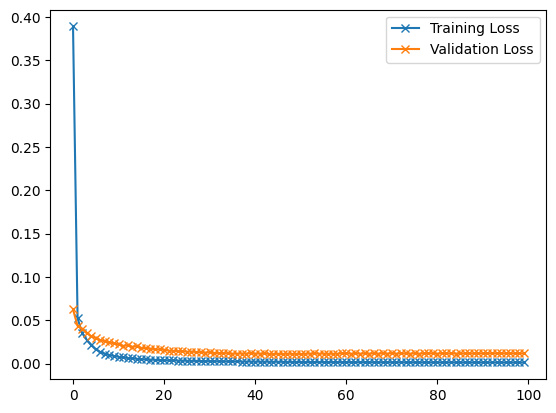

In [32]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

In [33]:
print(trainer)


        Model Properties:
        PerceptronBD(
  (model): Sequential(
    (0): Linear(in_features=6, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout1d(p=0.01, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=20, bias=True)
    (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout1d(p=0.01, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=20, out_features=80, bias=True)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
)
        Optimizer Properties"
        SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.004
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
        DataLoader Params: 
            Batch Size: 64
            Validation Method: Holds out fMaternal Wall Thickness columns 0.7281384947898918 for validation. The rest are used         

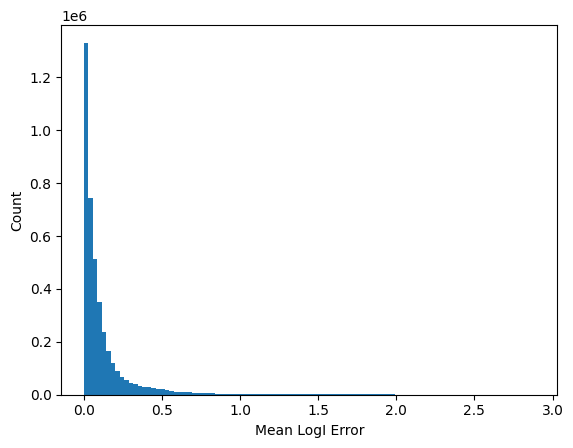

In [34]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    trainer.model = trainer.model.eval()
    predictions = trainer.model(x_data)
    # predictions = fwd_model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    # error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error})
plt.figure()
# error_df['%tage'].plot.hist(bins=100)
error_df['Absolute Error'].plot.hist(bins=100)
# plt.xlabel('(%) Error')
plt.xlabel('Mean LogI Error')
plt.ylabel('Count')
plt.show()

In [35]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [1.71026635e-05 3.75576552e-04 1.67512232e-03 3.39592166e-03
 7.71406227e-03 8.81783596e-03 1.04427778e-02 1.19389111e-02
 1.40543025e-02 1.59427953e-02 1.85486362e-02 2.08294886e-02
 1.36918594e-02 1.36889986e-02 1.36894497e-02 1.36930323e-02
 1.37015376e-02 1.37115636e-02 1.37281232e-02 1.37445925e-02
 1.29349849e-05 2.86748380e-04 1.66729182e-03 3.60234792e-03
 1.62888556e-02 2.01641526e-02 2.62534473e-02 3.21210217e-02
 4.07006631e-02 4.85605149e-02 5.96305031e-02 6.94826323e-02
 3.79041636e-02 3.87728484e-02 3.98870533e-02 4.08010965e-02
 4.19719995e-02 4.29314011e-02 4.41590021e-02 4.51637621e-02
 1.71026635e-05 3.75576552e-04 1.67512232e-03 3.39592166e-03
 7.71406227e-03 8.81783596e-03 1.04427778e-02 1.19389111e-02
 1.40543025e-02 1.59427953e-02 1.85486362e-02 2.08294886e-02
 1.36918594e-02 1.36889986e-02 1.36894497e-02 1.36930323e-02
 1.37015376e-02 1.37115636e-02 1.37281232e-02 1.37445925e-02
 1.29349849e-05 2.86748380e-04 1.66729182e-03 3.60234792

In [36]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       70
│    └─BatchNorm1d: 2-2                  20
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       220
│    └─BatchNorm1d: 2-6                  40
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       1,680
│    └─Flatten: 2-10                     --
Total params: 2,030
Trainable params: 2,030
Non-trainable params: 0

In [37]:
# model_name = 'forward_curve_fit_paramv2'
# import joblib
# # Save Model
# torch.save(trainer.model.state_dict(), rf'../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

['../models/forward_curve_fit_paramv2_yscaler']

In [38]:
# # Load Model Code
# import joblib
# model_name = 'forward_curve_fit_paramv1'
# fwd_model = PerceptronBD([5, 6, 8, 8], dropout_rates = [0.2, 0.2])
# fwd_model.load_state_dict(torch.load(rf'../models/{model_name}'))
# fwd_model = fwd_model.cuda()
# fwd_model = fwd_model.eval()
# # The input TMPs will already be scaled. No need to further use an x_scaler
# y_scaler_fwd = joblib.load(rf'../models/{model_name}_yscaler')
# x_scaler_fwd = joblib.load(rf'../models/{model_name}_xscaler')